 # Прогнозирование с использованием сиамских сетей

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from keras.layers import Input, Lambda, Dense
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Загрузка и обработка данных

In [ ]:
uri = open(".mongodb_token").read()

client = pymongo.MongoClient(uri)
db = client['heavymetals']
collection = db['heavymetals']

In [ ]:
df = pd.DataFrame(list(db.Fe_cor_indexes.find()))
df = df.dropna()

In [ ]:
Al = [200, 400, 800, 1200, 2500, 4000, 8000]
Fe = [250, 500, 1000, 1500, 2000, 3000, 4000]
V =  [0.5, 1, 2, 4, 6, 8, 10]
Ni = [1, 2, 3, 6, 9, 12, 15]
Cr = [1, 2, 3, 4, 6, 10, 15]
Pb = [1, 2, 4, 8, 12, 16, 20]
As = [0.1, 0.2, 0.4, 0.6, 0.9, 1.2, 1.6]

In [ ]:
def classDef(x,metClassRange):
  for i in range(len(metClassRange)):
    if (x < metClassRange[i]):
      return i
    elif (x >= metClassRange[len(metClassRange)-1]):
      return len(metClassRange)

In [ ]:
df = df.dropna()
df['Fe']=df['Fe'].dropna().map(lambda x: classDef(x,Fe))

In [ ]:
x = df[df.columns[:-3]].values
y = df[df.columns[-3]].values

dim_x = x.shape[1]
dim_y = len(set(y))

In [ ]:
# нормирование данных 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [ ]:
# разделение на выборки
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x_train, y_train)

## Проектирование сиамской сети

In [ ]:
# определение входов сети
left_input = Input(shape=(dim_x,))
right_input = Input(shape=(dim_x,))

In [ ]:
convnet = Sequential([
    Dense(512,activation='relu',input_dim=dim_x),
    Dense(256, activation='relu'),
    Dense(128, activation='relu')
])

In [ ]:
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [ ]:
# Получение L1-расстояния между двумя эмбедингами
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

In [ ]:
# добавление функции растояния между выходами из сети
L1_distance = L1_layer([encoded_l, encoded_r])

In [ ]:
prediction = Dense(1,activation='sigmoid')(L1_distance)

In [ ]:

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
siamese_net.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

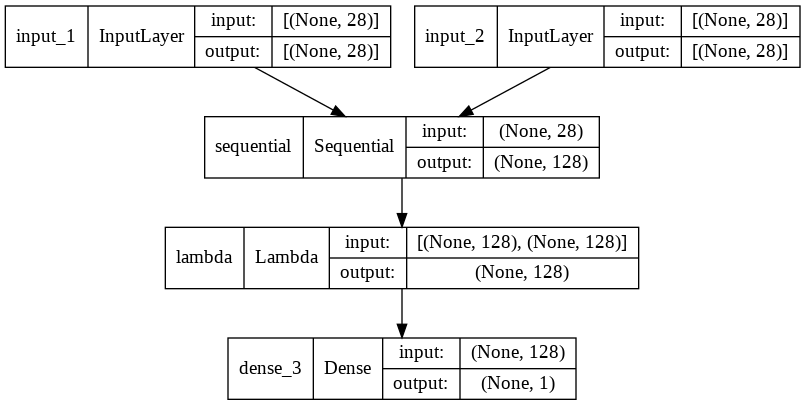

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(siamese_net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# генерация пар (случайным образом)

def make_pairs(x, y, pairs):
  left_input = []
  right_input = []
  targets = []

  for i in range(y.shape[0]):
    pos = 0
    neg = 0
    while (pos<pairs):
      compare_to = random.randint(0,y.shape[0]-1)
      if y[i] == y[compare_to]:
        left_input.append(x[i])
        right_input.append(x[compare_to])
        targets.append(1)
        pos=pos+1;

    while (neg<pairs):
      compare_to = random.randint(0,y.shape[0]-1)
      if y[i] != y[compare_to]:
        left_input.append(x[i])
        right_input.append(x[compare_to])
        targets.append(0)
        neg=neg+1


  left_input = np.squeeze(np.array(left_input))
  right_input = np.squeeze(np.array(right_input))
  targets = np.squeeze(np.array(targets))

  return left_input, right_input, targets

In [ ]:
left_input, right_input, targets = make_pairs(x_train, y_train, 3)
test_left,test_right, test_targets = make_pairs(x_test, y_test, 3)

In [ ]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=128,
          epochs=60,
          verbose=1,
		  validation_data=([test_left,test_right],test_targets)
          )

Epoch 1/60
470/470 [==============================] - 8s 16ms/step - loss: 0.6913 - accuracy: 0.5244 - val_loss: 0.6889 - val_accuracy: 0.5321
Epoch 2/60
470/470 [==============================] - 7s 15ms/step - loss: 0.6848 - accuracy: 0.5442 - val_loss: 0.6843 - val_accuracy: 0.5427
Epoch 3/60
470/470 [==============================] - 7s 15ms/step - loss: 0.6819 - accuracy: 0.5520 - val_loss: 0.6826 - val_accuracy: 0.5558
Epoch 4/60
470/470 [==============================] - 7s 15ms/step - loss: 0.6781 - accuracy: 0.5595 - val_loss: 0.6782 - val_accuracy: 0.5680
Epoch 5/60
470/470 [==============================] - 7s 15ms/step - loss: 0.6739 - accuracy: 0.5726 - val_loss: 0.6771 - val_accuracy: 0.5686
Epoch 6/60
470/470 [==============================] - 7s 16ms/step - loss: 0.6693 - accuracy: 0.5796 - val_loss: 0.6742 - val_accuracy: 0.5790
Epoch 7/60
470/470 [==============================] - 7s 16ms/step - loss: 0.6640 - accuracy: 0.5899 - val_loss: 0.6752 - val_accuracy: 0.5738